# Homework 2 Exercise 3
Now suppose the causal association between age and weight might be dif-
ferent for boys and girls. Use a single linear regression, with a categorical
variable for sex, to estimate the total causal effect of age on weight separately
for boys and girls. How do girls and boys differ? Provide one or more pos-
terior contrasts as a summary.

In [1]:
using StatsPlots
using StatisticalRethinking: sr_datadir, PI
using StatisticalRethinkingCommon
using Statistics, StatsBase
import CSV
using DataFrames
using Gen, Distributions

In [2]:
@time data = CSV.read(sr_datadir("Howell1.csv"), DataFrame)

 10.109705 seconds (2.99 M allocations: 136.090 MiB, 0.31% gc time, 99.97% compilation time)


,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


In [3]:
children = data[data.age .< 13 , :]
boys = children[children.male .== 1, :]
girls = children[children.male .== 0, :];

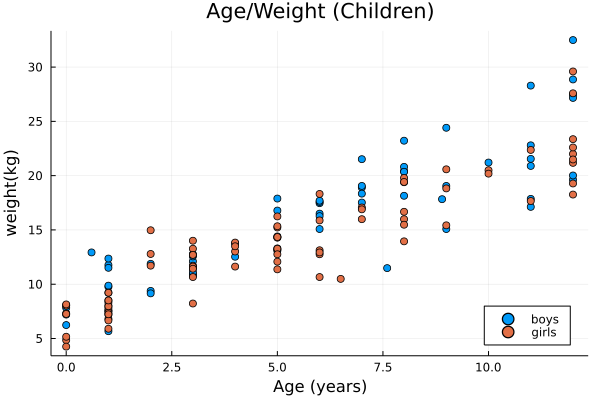

In [4]:
@df boys plot(:age, :weight, seriestype=:scatter, title="Age/Weight (Children)", xlabel="Age (years)", ylabel="weight(kg)", labels="boys", legend=:bottomright)
@df girls plot!(:age, :weight, seriestype=:scatter, labels="girls")

In [5]:
dt = standardize_column!(children, :age, scale=false)
StatsBase.transform!(dt,boys.age)
StatsBase.transform!(dt,girls.age)
dt

ZScoreTransform{Float64, Vector{Float64}}(1, 1, [5.401369863013698], Float64[])

In [6]:
@gen function children_age_weight_model(ages, males)
    a0 ~ normal(12., 7.5)
    b0 ~ gamma(0.25, 4.)
    noise0 ~ gamma(1., 1.)
    a1 ~ normal(12., 7.5)
    b1 ~ gamma(0.25, 4.)
    noise1 ~ gamma(1., 1.)
    a = [a0 a1]
    b = [b0 b1]
    noise = [noise0 noise1]
    
    function f(age,male)
        return a[male+1] + b[male+1] * age
    end
    
    for (i,age) in enumerate(ages)
        male = Int(males[i])
        {(:y, i)} ~ normal(f(age, male), noise[male+1])
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##children_age_weight_model#286", Bool[0, 0], false)

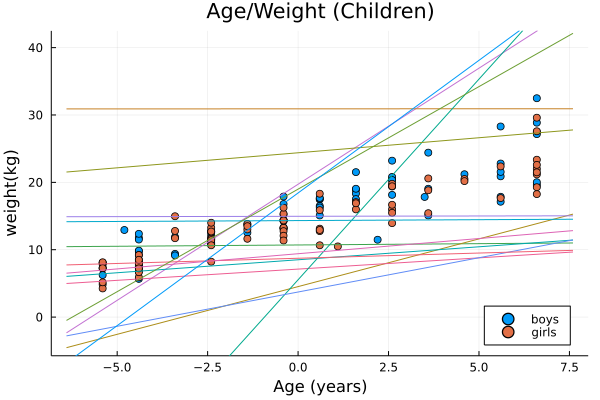

In [7]:
@df boys plot(:age, :weight, seriestype=:scatter, title="Age/Weight (Children)", xlabel="Age (years)", ylabel="weight(kg)", labels="boys", legend=:bottomright)
@df girls plot!(:age, :weight, seriestype=:scatter, labels="girls")
priors = [children_age_weight_model((), ()) for _ in 1:15]
test_xs = Vector(range(minimum(children.age)-1, maximum(children.age)+1, length=1000))
plot!(test_xs, [f.(test_xs, zeros(Int8,1000)) for f in priors[1:7]], labels=nothing)
plot!(test_xs, [f.(test_xs, ones(Int8,1000)) for f in priors[8:end]], labels=nothing)
plot!(ylim=(minimum(children.weight) - 10, maximum(children.weight) + 10))

In [8]:
observations = Gen.choicemap()
for (i,weight) in enumerate(children.weight)
    observations[(:y, i)] = weight
end

@time traces, = mcmc(children_age_weight_model, (children.age, children.male), observations, warmup=1_500, steps=15_000);

  3.385212 seconds (62.87 M allocations: 2.488 GiB, 6.95% gc time, 32.57% compilation time)


In [9]:
params = (:a0, :a1, :b0, :b1, :noise0, :noise1)

@time inferred,logweight = infer(traces, children_age_weight_model, (children.age,children.male), params)
a0 = inferred[:a0]
b0 = inferred[:b0]
noise0 = inferred[:noise0]
a1 = inferred[:a1]
b1 = inferred[:b1]
noise1 = inferred[:noise1]
@info "Parameters:" a0 b0 noise0 a1 b1 noise1

  0.534202 seconds (2.24 M allocations: 154.638 MiB, 98.80% compilation time)


┌ Info: Parameters:
│   a0 = 10.635016825686824
│   b0 = 0.49261873832279296
│   noise0 = 7.458569328252176
│   a1 = 13.860815432368355
│   b1 = 1.2859784465749355
│   noise1 = 2.632273656946618
└ @ Main In[9]:10


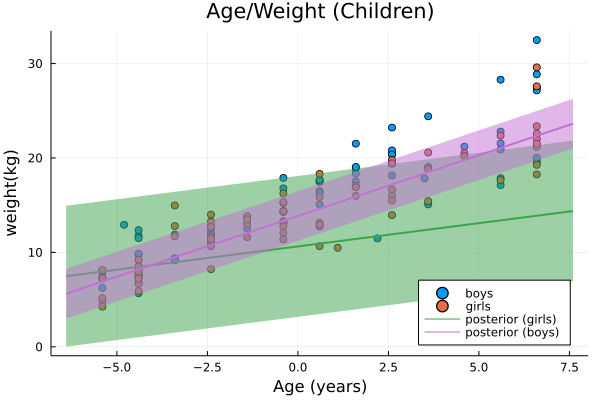

In [10]:
@df boys plot(:age, :weight, seriestype=:scatter, title="Age/Weight (Children)", xlabel="Age (years)", ylabel="weight(kg)", labels="boys", legend=:bottomright)
@df girls plot!(:age, :weight, seriestype=:scatter, labels="girls")
plot!(test_xs, (@. a0 + b0 * test_xs), linewidth=2., ribbon=noise0, labels="posterior (girls)")
plot!(test_xs, (@. a1 + b1 * test_xs), linewidth=2., ribbon=noise1, labels="posterior (boys)")

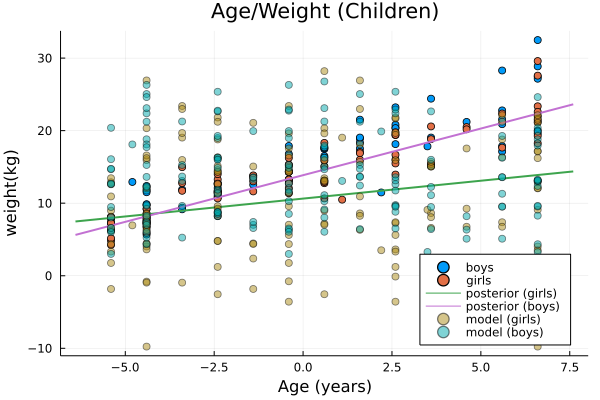

In [11]:
@df boys plot(:age, :weight, seriestype=:scatter, title="Age/Weight (Children)", xlabel="Age (years)", ylabel="weight(kg)", labels="boys", legend=:bottomright)
@df girls plot!(:age, :weight, seriestype=:scatter, labels="girls")
plot!(test_xs, (@. a0 + b0 * test_xs), labels="posterior (girls)", linewidth=2.)
plot!(test_xs, (@. a1 + b1 * test_xs), labels="posterior (boys)", linewidth=2.)
test_predictions_girls = @. rand(Normal(a0 + b0 * girls.age, noise0))
test_predictions_boys = @. rand(Normal(a1 + b1 * girls.age, noise1))
plot!(children.age, test_predictions_girls, seriestype=:scatter, alpha=1/2, label="model (girls)")
plot!(children.age, test_predictions_boys, seriestype=:scatter, alpha=1/2, label="model (boys)")